Tutorial 3: Realism and Complexity
==================================

Up to now, we've fitted some fairly crude and unrealistic lens models. For example, we've modeled the lens galaxy's
mass as a sphere. Given most lens galaxies are `elliptical`s we should probably model their mass as elliptical! We've
also omitted the lens galaxy's light, which typically outshines the source galaxy.

In this example, we'll start using a more realistic lens model.

In my experience, the simplest lens model (e.g. that has the fewest parameters) that provides a good fit to real
strong lenses is as follows:

 1) An _EllipticalSersic `LightProfile` for the lens galaxy's light.
 2) A `EllipticalIsothermal` (SIE) `MassProfile` for the lens galaxy's mass.
 3) An `EllipticalExponential` `LightProfile`.for the source-`Galaxy`'s light (to be honest, this is too simple,
 but lets worry about that later).

This has a total of 18 non-linear parameters, which is over double the number of parameters we've fitted up to now.
In future exercises, we'll fit even more complex models, with some 20-30+ non-linear parameters.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use new strong lensing data, where:

 - The lens galaxy's `LightProfile` is an `EllipticalSersic`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we'll create and use a 2.5" `Mask2D`.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.5
)

When plotted, the lens light`s is clearly visible in the centre of the image.

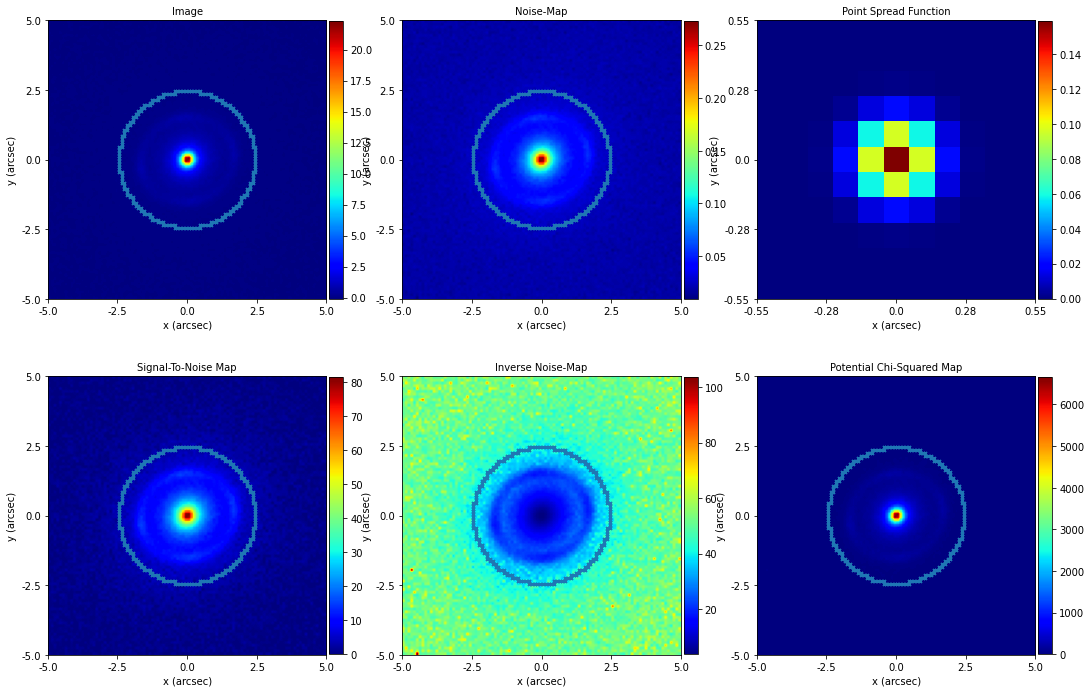

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Like in the previous tutorial, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

Now lets fit the dataset using a phase.

In [6]:
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens",
        name="phase_t3_realism_and_complexity",
        n_live_points=80,
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens_galaxy=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source_galaxy=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential),
    ),
)

Lets run the phase.

In [7]:
print(
    "Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:phase_t3_realism_and_complexity already completed, skipping non-linear search.


Dynesty has finished run - you may now continue the notebook.


And lets look at the fit to the `Imaging` data, which as we are used to fits the data brilliantly!

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


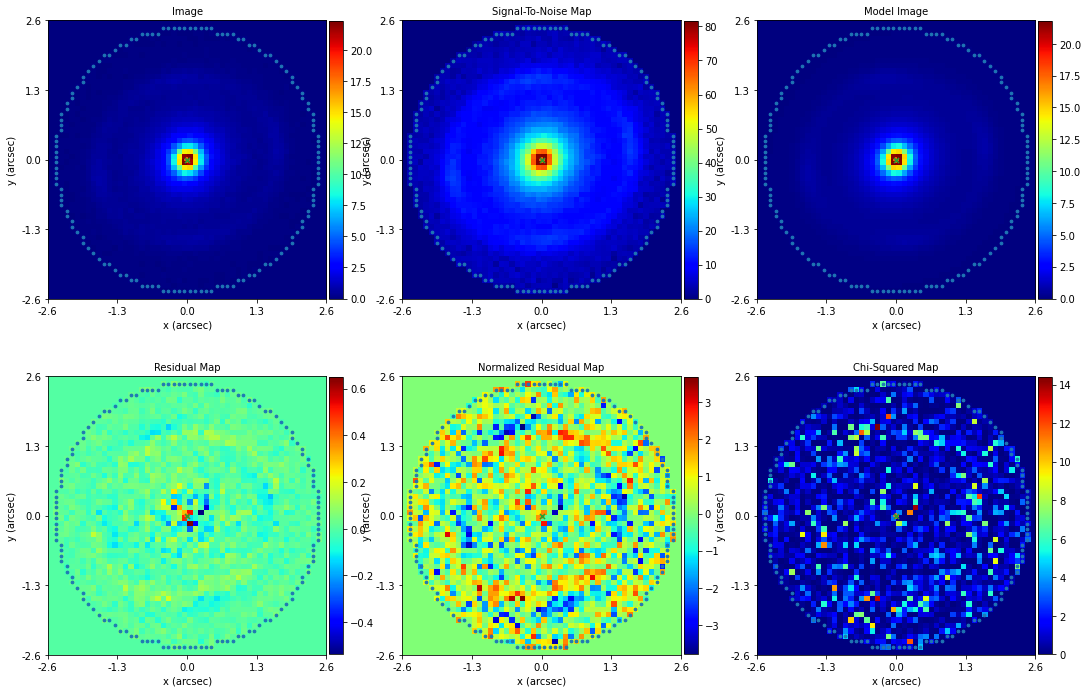

In [8]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Up to now, all of our non-linear searches have been successes. They find a lens model that provides a visibly good fit
to the data, minimizing the residuals and inferring a high log likelihood value. 

These solutions are called `global` maxima, they correspond to the highest likelihood regions of the entirity of 
parameter space. There are no other lens models in parameter space that would give higher likelihoods - this is the
model we wants to always infer!

However, non-linear searches may not always successfully locate the global maxima lens models. They may instead infer 
a `local maxima`, a solution which has a high log likelihood value relative to the lens models near it in parameter 
space, but whose log likelihood is significantly below the `global` maxima solution somewhere else in parameter space. 

Inferring such solutions is essentially a failure of our `NonLinearSearch` and it is something we do not want to
happen! Lets infer a local maxima, by reducing the number of `live points` Dynesty uses to map out parameter space.
we're going to use so few that it has no hope of locating the global maxima, ultimating finding and inferring a local 
maxima instead.

In [9]:
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens",
        name="phase_t3_realism_and_complexity__local_maxima",
        n_live_points=5,
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens_galaxy=al.GalaxyModel(
            redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source_galaxy=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential),
    ),
)

print(
    "Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_local_maxima = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:phase_t3_realism_and_complexity__local_maxima already completed, skipping non-linear search.


Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


And lets look at the fit to the `Imaging` data, which is clearly worse than our original fit above.

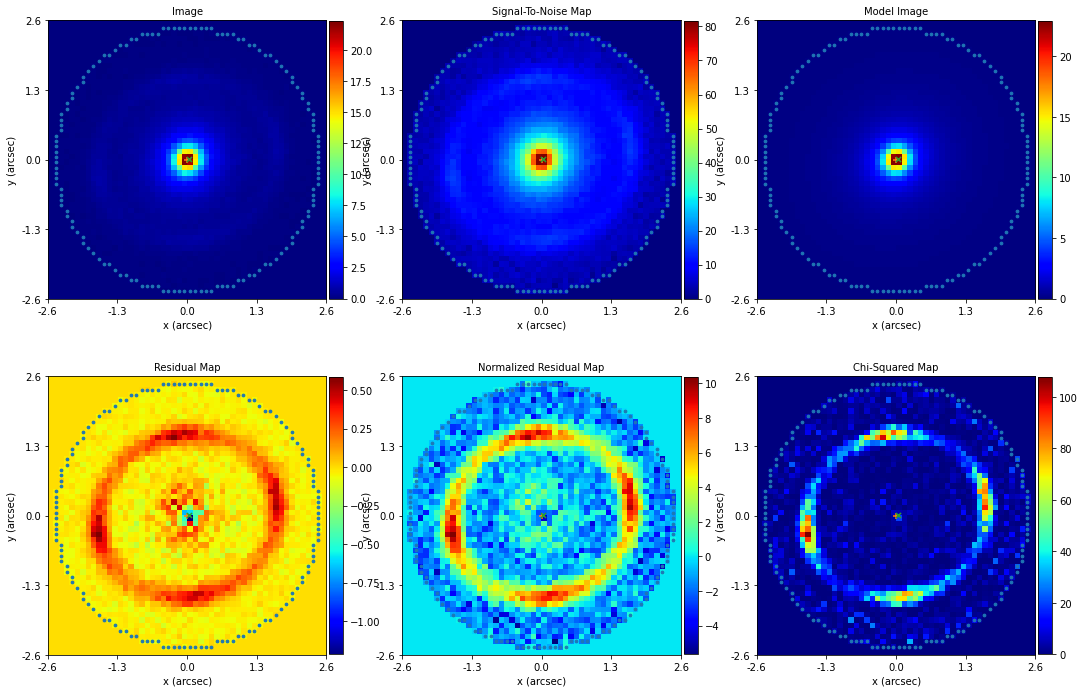

In [10]:
fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_local_maxima.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

Finally, just to be sure we hit a local maxima, lets compare the maximum log likelihood values of the two results 

The local maxima value is significantly lower, confirming that our `NonLinearSearch` simply failed to locate lens 
models which fit the data better when it searched parameter space.

In [11]:
print("Likelihood of Global Model:")
print(result.max_log_likelihood_fit.log_likelihood)
print("Likelihood of Local Model:")
print(result_local_maxima.max_log_likelihood_fit.log_likelihood)

Likelihood of Global Model:
3332.709427152766
Likelihood of Local Model:
-2559.094402493678


In this example, we intentionally made our `NonLinearSearch` fail, by using so few live points it had no hope of 
sampling parameter space thoroughly. For modeling real lenses we wouldn't do this on purpose, but the risk of inferring 
a local maxima is still very real, especially as we make our lens model more complex.

Lets think about *complexity*. As we make our lens model more realistic, we also made it more complex. For this 
tutorial, our non-linear parameter space went from 7 dimensions to 18. This means there was a much larger *volume* of 
parameter space to search. As this volume grows, there becomes a higher chance that our `NonLinearSearch` gets lost 
and infers a local maxima, especially if we don't set it up with enough live points!

At its core, lens modeling is all about learning how to get a `NonLinearSearch` to find the global maxima region of 
parameter space, even when the lens model is extremely complex.

And with that, we're done. In the next exercise, we'll learn how to deal with failure and begin thinking about how we 
can ensure our `NonLinearSearch` finds the global-maximum log likelihood solution. Before that, think about 
the following:

 1) When you look at an image of a strong lens, do you get a sense of roughly what values certain lens model 
 parameters are?
    
 2) The `NonLinearSearch` failed because parameter space was too complex. Could we make it less complex, whilst 
 still keeping our lens model fairly realistic?
    
 3) The source galaxy in this example had only 7 non-linear parameters. Real source galaxies may have multiple 
 components (e.g. a bar, disk, bulge, star-forming knot) and there may even be more than 1 source galaxy! Do you 
 think there is any hope of us navigating a parameter space if the source contributes 20+ parameters by itself?